In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
#https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/image/__init__.py
from tensorflow_addons.image.color_ops import sharpness
from tensorflow_addons.image.filters import gaussian_filter2d
from tensorflow_addons.image.dense_image_warp import dense_image_warp

In [3]:
#!pip install tensorflow_datasets

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #CPU

In [5]:
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.3.0', True)

In [6]:
max_sequence = 9
blank_num = -1
characters_0 = '0123456789'
characters_alphabet = 'ABCDEFGHIJKLMNPQRSTUVWXYZ-'
characters_1 = '가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주'
characters_1d = 'GNDLMBSOJHgndlmbsojhgNDLMBSOJHGNDLMBSUJ'
characters_2 = '대배해제기교표외인천국합육공영준협정울경강원충북운남전산광'
characters_2d = 'DBHJGGPYICGHUGYJHJUGKWCBUNJSG'
characters_3 = '_       abcd  '
plate_characters = characters_0 + characters_alphabet + characters_1 + characters_2 + characters_3
num_classes = len(plate_characters)
num_classes

118

In [7]:
plate_characters

'0123456789ABCDEFGHIJKLMNPQRSTUVWXYZ-가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주대배해제기교표외인천국합육공영준협정울경강원충북운남전산광_       abcd  '

In [529]:
padded_image_shape = (16*6, 16*6*3)
EOS = num_classes - 1
SOS = EOS - 1
head_n = 8
l1 = 1e-8
activation = 'relu'#'selu' is not converted to tflite
kernel_init = tf.initializers.he_normal()
path_weight = "model/LPR"
max_data_m = 10000
scale_margin = 0.01
SOS, EOS

(116, 117)

In [9]:
path_synthetic = '/home/mvlab/Downloads/plate_generator/gen/'
path_label = path_synthetic + 'label.csv'

In [10]:
os.path.isdir(path_synthetic), os.path.isfile(path_label)

(True, True)

In [11]:
np.set_printoptions(precision=3)

In [12]:
df = pd.read_csv(path_label, sep=' ')
df.shape

(6251, 29)

In [13]:
df.columns

Index(['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17'],
      dtype='object')

In [14]:
df.head()

,path,x0,y0,x1,y1,x2,y2,x3,y3,type,...,8,9,10,11,12,13,14,15,16,17
0,1_49소4994.png,263,56,782,56,782,165,263,165,1,...,608,110,665,110,723,110,0.0,0.0,0.0,0.0
1,1_87거5293.png,260,55,779,55,779,164,260,164,1,...,601,109,658,109,715,109,0.0,0.0,0.0,0.0
2,1_52머9472.png,262,50,781,50,781,159,262,159,1,...,598,104,654,104,710,104,0.0,0.0,0.0,0.0
3,1_20모3579.png,260,55,779,55,779,164,260,164,1,...,600,109,657,109,714,109,0.0,0.0,0.0,0.0
4,1_79노4785.png,255,52,774,52,774,161,255,161,1,...,600,106,658,106,715,106,0.0,0.0,0.0,0.0


In [15]:
df['type'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [16]:
df.iloc[0]

path    1_49소4994.png
x0                263
y0                 56
x1                782
y1                 56
x2                782
y2                165
x3                263
y3                165
type                1
text          49소4994
0                 336
1                 110
2                 394
3                 110
4                 464
5                 104
6                 550
7                 110
8                 608
9                 110
10                665
11                110
12                723
13                110
14                  0
15                  0
16                  0
17                  0
Name: 0, dtype: object

In [17]:
def read_synthetic(max_m=10000):
    df = pd.read_csv(path_label, sep=' ')
    df = df[:max_m]
    m = len(df)
    x0 = df['x0']
    x1 = df['x1']
    x2 = df['x2']
    x3 = df['x3']
    y0 = df['y0']
    y1 = df['y1']
    y2 = df['y2']
    y3 = df['y3']
    
    min_x = np.minimum(df['x0'], df['x3'])
    min_y = np.minimum(df['y0'], df['y1'])
    max_x = np.maximum(df['x1'], df['x2'])
    max_y = np.maximum(df['y2'], df['y3'])
    box_ratio = (max_x - min_x) / (max_y - min_y)
    shear_y0 = -box_ratio * (y2 - y3) / (x2 - x3)
    shear_y1 = -box_ratio * (y1 - y0) / (x1 - x0)
    shear_x0 = -box_ratio * (x3 - x0) / (y3 - y0)
    shear_x1 = -box_ratio * (x2 - x1) / (y2 - y1)
    shear_y = (shear_y0 + shear_y1) / 2
    shear_x = (shear_x0 + shear_x1) / 2
    df['min_x'] = min_x
    df['min_y'] = min_y
    df['max_x'] = max_x
    df['max_y'] = max_y
    df['shear_x'] = shear_x
    df['shear_y'] = shear_y

    plate_chars = plate_characters
    bbox = df[['min_x', 'min_y', 'max_x', 'max_y', 'type']].values
    vertex = df[['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3','type']].values
    cxy_col = [str(i) for i in range(18)]
    char_cxy = df[cxy_col].values
    plate_type = df['type'].values

    text_len = max_sequence
    m = len(df)
    class_nums = np.zeros((m, text_len)) - 1
    for i in range(m):
        text0 = df.loc[i, 'text']
        for j in range(len(text0)):
            class_num = plate_chars.index(text0[j])
            class_nums[i, j] = class_num
    print('class_nums', class_nums.shape)
    print('char_cxy', char_cxy.shape)
    
    label = np.concatenate((vertex, class_nums, char_cxy), axis=-1)    
    print('label', label.shape)
    
    img_path_list = list(path_synthetic + df['path'].values)
    return img_path_list, label

In [18]:
EOS

117

In [19]:
paths_synthetic, labels_synthetic = read_synthetic(10000)
print('labels', len(labels_synthetic), len(paths_synthetic))
print(labels_synthetic[0])

class_nums (6251, 9)
char_cxy (6251, 18)
label (6251, 36)
labels 6251 6251
[263.  56. 782.  56. 782. 165. 263. 165.   1.   4.   9.  62.   4.   9.
   9.   4.  -1.  -1. 336. 110. 394. 110. 464. 104. 550. 110. 608. 110.
 665. 110. 723. 110.   0.   0.   0.   0.]


In [20]:
i_index = np.arange(10)
np.random.shuffle(i_index)
i_index

array([1, 6, 4, 2, 0, 8, 7, 5, 3, 9])

In [130]:
x_list_synthetic = []
y_list_synthetic = []
i_index = np.arange(len(paths_synthetic))
np.random.shuffle(i_index)
for i in i_index:
    path_img = paths_synthetic[i]
    label = labels_synthetic[i]
    if os.path.isfile(path_img):
        img = Image.open(path_img)
        arr = np.array(img)
        
        
        img_h, img_w, img_c = arr.shape
        #print('label', label.shape)
        coord = label[:8]
        type_text = label[8:8+1+max_sequence]        
        char_cxy = label[8+1+max_sequence:]
        
        coord_2d = np.reshape(coord, [-1, 2])
        coord_2d_norm = coord_2d / (np.array((img_w, img_h), np.float))
        coord_norm = np.reshape(coord_2d_norm, [-1])
        
        char_cxy_2d = np.reshape(char_cxy, [-1, 2])
        char_cxy_2d_norm = char_cxy_2d / (np.array((img_w, img_h), np.float))
        char_cxy_norm = np.reshape(char_cxy_2d_norm, [-1])
        
        label_norm = np.concatenate((coord_norm, type_text, char_cxy_norm), -1)
        
        x_list_synthetic.append(arr)
        y_list_synthetic.append(label_norm)
        if len(x_list_synthetic) % 500 == 0 :
            print(len(paths_synthetic), len(x_list_synthetic))
        if len(x_list_synthetic)>max_data_m:
            break
print('x_list', len(x_list_synthetic), len(y_list_synthetic))

6251 500
6251 1000
6251 1500
6251 2000
6251 2500
6251 3000
6251 3500
6251 4000
6251 4500
6251 5000
6251 5500
6251 6000
x_list 6251 6251


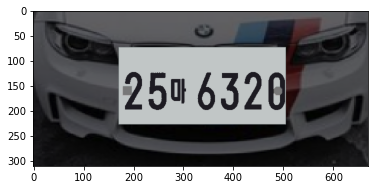

In [22]:
plt.imshow(x_list_synthetic[0])

In [23]:
def visualize_plate(
    image, y, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""    
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    vertices_norm = y[:8]    
    plate_type = y[8]
    plate_text = y[9:]
    vertices_norm_2d = np.reshape(vertices_norm, [-1, 2])
    vertices_2d = vertices_norm_2d * np.array((img_w, img_h), np.float)
    
    x0, y0, x1, y1, x2, y2, x3, y3 = np.reshape(vertices_2d, [-1])
    
    w, h = x2 - x1, y2 - y1    
    color = [1,0,0]
    linewidth = 10
    plt.plot(x0, y0, x1, y1, 'go-', linewidth=linewidth)
    plt.plot(x1, y1, x2, y2, 'ro--', linewidth=linewidth)
    plt.plot(x2, y2, x3, y3, marker = 'o', linewidth=linewidth)
    plt.plot(x3, y3, x0, y0, marker = 'o', linewidth=linewidth)
        
    txt = str.format('(%d)' % (plate_type)) + str(plate_text)
    ax.text(x0, y0, txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

In [24]:
def display_data(X, Y, stride=1):
    for i in range(len(X)):
        if i%stride==0:            
            ax = visualize_plate(X[i], Y[i])

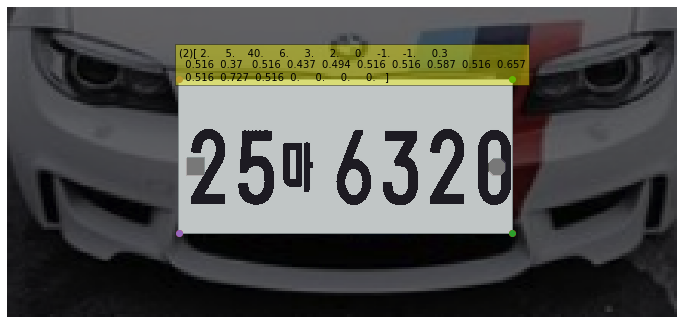

In [25]:
display_data(x_list_synthetic, y_list_synthetic, stride=10000)

In [193]:
def read_HK(max_m, is_synthetic=False):
    
    path_root = '/home/mvlab/'
    if is_synthetic:
        path_pre = path_root + 'PycharmProjects/plate_gen/gen/'
        path_label = 'label.csv'
        df = pd.read_csv(path_pre + path_label, sep=' ')
    else:
        path_pre = path_root + 'Downloads/dataset/HK_dataset/'
        path_label = 'HK_dataset_20200101.txt'
        df = pd.read_csv(path_pre + path_label, sep=' ', header=None)
        columns = ['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text']
        df.columns = columns

    print('csv_path', path_pre + path_label)
    print('df.shape',df.shape)
    print('unique_path',df['path'].nunique())
    print('per_type_count')
    print(df['type'].value_counts())

    m = np.minimum(max_m, len(df))
    df = df[:m]

    print('unique_path', len(df), df['path'].nunique())
    print('duplicated', df.duplicated(subset=None, keep='first').sum())
    print('duplicated[path]', df['path'].duplicated().sum())
    duple_index = df[df['path'].duplicated()].index
    #print('duplicated', df[df['path'].duplicated()])
    #duple_concat = pd.concat((df.iloc[duple_index,['path', 'text']],df.iloc[duple_index+1,'path', 'text']))
    #print(df.iloc[duple_index-1])
    #print(df.iloc[duple_index])
    for i in range(len(df)):
        if not os.path.exists(path_pre + df.loc[i, 'path']):
            print('drop_not_exist_path', df.loc[i, 'path'])
            df = df.drop(index=i)

    df['path'] = path_pre + df['path']
    labels = df.values

    paths = df['path'].values
    labels = split_text(labels)
    return df.columns, labels, paths

def split_text(labels):

    #import environment as env
    new_labels = []
    for i in range(len(labels)):
        label = labels[i]
        #print('label',i,label)
        coord = label[1:10]
        text = label[10]
        char_position = label[11:]

        text_arr = np.array(list(text))
        text_num = np.zeros(max_sequence, np.int32) + blank_num
        for k in range(len(text_arr)):            
            try:
                index = plate_characters.index(text_arr[k])
            except:
                print('exception_split_text', text_arr[k],'in',text)
                exit()
            text_num[k] = index

        label_arr = np.concatenate((coord, text_num, char_position), -1)
        new_labels.append(label_arr)
        #new_labels.append(np.stack(new_label, 0))

    new_labels = np.stack(new_labels, 0)
    c = np.shape(label_arr)[-1]
    new_labels = np.reshape(new_labels, [-1, c])
    print('new_labels', new_labels.shape, new_labels[0], 'max', np.max(new_labels))

    return new_labels


def exploration_low_frequency_class(numbers):
    print('numbers', numbers.shape)
    numbers_flat = np.reshape(numbers, [-1])
    characters = []
    for i in range(len(numbers_flat)):
        characters.append(plate_characters[numbers_flat[i]])
    print('characters', characters)
    characters_flat = np.reshape(characters, [-1])
    df_num = pd.DataFrame(numbers_flat)
    df = pd.DataFrame(characters_flat)
    char_value_count = df[0].value_counts()
    class_count = df_num[0].value_counts()
    thresh = len(numbers)*0.01
    #print('characters_flat', char_value_count[char_value_count<thresh])
    print('characters_flat', char_value_count[char_value_count<thresh])
    print('class_count', class_count[class_count<thresh])
    sparse_class_num = class_count[class_count < thresh].index
    print('sparse_class', sparse_class_num)
    return sparse_class_num

def exploration(types, numbers):
    #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    #weight_for_0 = (1 / neg) * (total) / 2.0
    #weight_for_1 = (1 / pos) * (total) / 2.0
    #set_chinese()
    import matplotlib as mpl

    print('types', types)

    if True:
        types_flat = np.reshape(types, [-1]).astype(np.int)
        df = pd.DataFrame(types_flat)
        value_count = df[0].value_counts()
        print('LP types', value_count)
        max_freq_c1 = max(value_count)
        print('types frequency', max_freq_c1, max_freq_c1/sum(value_count))

    plt.hist(types)
    plt.savefig('types.png')
    plt.close()
    m = len(numbers)
    char_number_flat = np.reshape(numbers, [-1]).astype(np.int)
    df = pd.DataFrame(char_number_flat)
    print('df', df.shape)
    china_char = df[0]
    china_char_count_sort = china_char.value_counts()
    print(china_char_count_sort)

    if True:
        value = df[0]
        cond_0 = value < 10
        cond_1 = np.logical_and(value >= 10+25, value < k-5)
        class_0 = df[cond_0][0]
        class_1 = df[cond_1][0]
        max_freq_c1 = max(class_1.value_counts())
        len_cond_0 = max(class_0) - min(class_0) + 1
        len_cond_1 = max(class_1) - min(class_1) + 1
        #plt.figure(figsize=(10, 5))
        plt.hist(class_0, bins=len_cond_0, color='r', label='digit')
        plt.hist(class_1, bins=len_cond_1, color='g', label='Korean')
        plt.legend()
        from matplotlib import font_manager
        fontP = font_manager.FontProperties()
        #fontP.set_file('../simhei.ttf')
        #plt.legend(prop=fontP)
        x_label = plate_characters
        #plt.xlabel(x_label, fontproperties=fontP)

        print('unique_character', value.nunique(), value.unique())
        print('alphabet frequency', max_freq_c1, max_freq_c1/sum(cond_1))
        plt.savefig('char_count_all.png')
        plt.close()

    frequency = np.zeros(k)
    cls_num = china_char_count_sort.index
    cls_freq = china_char_count_sort.values
    frequency[cls_num] = cls_freq
    #weight = ((1+frequency) / np.sum(frequency))
    np.set_printoptions(precision=4, suppress=True, linewidth=150)
    print('frequency', frequency)


def get_class_index(m):
    info, labels, paths = generate_HK_GT(m, is_synthetic=False)
    cls = labels[:, 9:]
    char_number_flat = np.reshape(cls, [-1]).astype(np.int)
    df = pd.DataFrame(char_number_flat)
    cls_unique = df[0].value_counts()
    print('cls_unique', cls_unique)
    print('index', cls_unique.index)
    cls_unique = cls_unique.index[cls_unique.index<100]
    print('cls_unique', cls_unique)
    return cls_unique

In [194]:
m = 2500
#get_class_index(100)

info, labels, paths = read_HK(m, is_synthetic=False)
print('info', info)
print('labels', len(labels), len(paths), labels[0])

csv_path /home/mvlab/Downloads/dataset/HK_dataset/HK_dataset_20200101.txt
df.shape (1469, 11)
unique_path 1437
per_type_count
1    1027
3     170
4     126
2     110
5      33
6       3
Name: type, dtype: int64
unique_path 1469 1437
duplicated 0
duplicated[path] 32
drop_not_exist_path plate1(1021).jpg
new_labels (1468, 18) [403 325 567 276 569 313 405 366 1 4 9 56 0 1 5 1 -1 -1] max 2732
info Index(['path', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'type', 'text'], dtype='object')
labels 1468 1468 [403 325 567 276 569 313 405 366 1 4 9 56 0 1 5 1 -1 -1]


In [195]:
x_list_hk = []
y_list_hk = []
for i in range(len(paths)):
    path_img = paths[i]
    label = labels[i]
    if os.path.isfile(path_img):
        img = Image.open(path_img)
        arr = np.array(img)        
        
        img_h, img_w, img_c = arr.shape
        #print('label', label.shape)
        coord = label[:8]
        type_text = label[8:]
        text_cxy = np.zeros(max_sequence*2)+2
        coord_2d = np.reshape(coord, [-1, 2])
        coord_2d_norm = coord_2d / (np.array((img_w, img_h), np.float))
        coord_norm = np.reshape(coord_2d_norm, [-1])
        label_norm = np.concatenate((coord_norm, type_text, text_cxy), -1)
        
        x_list_hk.append(arr)
        y_list_hk.append(label_norm)
        if len(x_list_hk) % 100==0:
            print(len(paths), len(x_list_hk))
        
    else:
        print('no_file', path_img)
        
print('x_list_hk', len(x_list_hk), len(y_list_hk), y_list_hk[0])

1468 100
1468 200
1468 300
1468 400
1468 500
1468 600
1468 700
1468 800
1468 900
1468 1000
1468 1100
1468 1200
1468 1300
1468 1400
x_list_hk 1468 1468 [0.4197916666666667 0.6018518518518519 0.590625 0.5111111111111111
 0.5927083333333333 0.5796296296296296 0.421875 0.6777777777777778 1 4 9
 56 0 1 5 1 -1 -1 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0
 2.0 2.0 2.0 2.0]


In [196]:
len(y_list_synthetic[0]), len(y_list_hk[0])

(36, 36)

In [197]:
y_list_synthetic[0], y_list_hk[0]

(array([ 0.25,  0.25,  0.75,  0.25,  0.75,  0.75,  0.25,  0.75, 10.  ,
        95.  , 96.  ,  2.  , 73.  , 49.  , 73.  , 53.  , 71.  , 49.  ,
         0.4 ,  0.35,  0.47,  0.35,  0.54,  0.34,  0.61,  0.37,  0.3 ,
         0.53,  0.39,  0.54,  0.48,  0.53,  0.58,  0.54,  0.67,  0.54]),
 array([0.4197916666666667, 0.6018518518518519, 0.590625,
        0.5111111111111111, 0.5927083333333333, 0.5796296296296296,
        0.421875, 0.6777777777777778, 1, 4, 9, 56, 0, 1, 5, 1, -1, -1, 2.0,
        2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,
        2.0, 2.0, 2.0, 2.0], dtype=object))

In [ ]:
display_data(x_list_hk, y_list_hk, stride=100)

In [ ]:
len(y_list_synthetic), len(x_list_hk)

In [131]:
x_list_train = x_list_synthetic.copy()
y_list_train = y_list_synthetic.copy()

In [497]:
stride = len(x_list_synthetic) // len(x_list_hk) // 2
x_list_train = x_list_synthetic.copy()
y_list_train = y_list_synthetic.copy()
len(x_list_train)

6251

In [498]:
for iter in range(3):
    idx = np.arange(len(x_list_hk)//2)
    np.random.shuffle(idx)
    for j in range(len(x_list_hk)//2):
        i = idx[j]
        x_list_train.insert(i*stride, x_list_hk[i*2])
        y_list_train.insert(i*stride, y_list_hk[i*2])
    len(x_list_train)

In [499]:
x_list_test = x_list_hk[::2]
y_list_test = y_list_hk[::2]
len(x_list_train), len(x_list_test)

(8453, 734)

In [199]:
def shift_matrix(x, y):
    z = x * 0
    o = z + 1
    mat = tf.stack([o, z, x, z, o, y], -1)
    row = tf.stack([z, z, z+1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def scale_matrix(x, y):
    z = x * 0
    mat = tf.stack([x, z, z, z, y, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def rotate_matrix(radian):
    c = tf.cos(radian)
    s = tf.sin(radian)
    z = c * 0
    mat = tf.stack([c, -s, z, s, c, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


def shear_x_matrix(radian_x):
    x = tan(radian_x)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, z, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_y_matrix(radian_y):
    y = tan(radian_y)
    z = y * 0
    o = z + 1
    mat = tf.stack([o, z, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat

def shear_matrix(radian_x, radian_y):
    
    x = tan(radian_x)
    y = tan(radian_y)
    z = x * 0
    o = z + 1
    mat = tf.stack([o, x, z, y, o, z], -1)
    row = tf.stack([z, z, z + 1], -1)
    mat = tf.concat((mat, row), -1)
    mat = tf.reshape(mat, [-1, 3, 3])
    return mat


In [200]:
x_list_hk.extend(x_list)
y_list_hk.extend(y_list)
x_list = x_list_hk
y_list = y_list_hk

NameError: name 'x_list' is not defined

In [201]:
def convert_norm_to_uv(coord):
    return coord * 2 - 1 

def convert_uv_to_norm_to(coord):
    return coord + 1 / 2


def transform_uv(uv, mat):
    #coord : (m, n, 2)
    #theta : (m, 2, 3)    
    inv_mat = tf.linalg.inv(mat)        
    xyo = tf.concat((uv, 1 + 0 * uv[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', inv_mat, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])
    new_xy = new_xy[:, :, :2]
    return new_xy


def transform_xy(xy, theta):
    m = tf.shape(xy)[0]
    theta = tf.linalg.inv(theta)
    theta = theta[:, :2]
    # xy [0, 1] > [-1, 1]
    xy = (xy - 0.5) * 2
    theta = tf.reshape(theta, [-1, 2, 3])
    xy = tf.reshape(xy, [m, -1, 2])
    xyo = tf.concat((xy, 1 + 0 * xy[:, :, :1]), -1)
    new_xy = tf.einsum('mrc,msc->mrs', theta, xyo)
    new_xy = tf.transpose(new_xy, [0, 2, 1])

    return new_xy

In [202]:
#y = sign(x) = -1 if x < 0; 0 if x == 0; 1 if x > 0.
def sign(v):
    return tf.cast(v > 0, tf.float32) + -1 * tf.cast(v < 0, tf.float32)

def tan(v):
    return tf.sin(v)/tf.cos(v)

In [203]:
def get_x1(t1, t2, width, height):
    a = sign(t2) * width - height * tf.sin(t2)/tf.cos(t2)
    b = (sign(t2) * tf.cos(t1) * tf.cos(t2) - sign(t1) * tf.sin(t1) * tf.sin(t2)) / (tf.cos(t1)*tf.cos(t2))
    x1 = a / b
    return x1

def get_v1_v2(t1, t2, width, height):
    x1 = get_x1(t1, t2, width, height)
    #x1 = get_x1_new(t1, t2, width, height)
    y1 = x1 / tf.cos(t1) * tf.sin(t1)
    x2 = width * sign(t2) - sign(t2) * x1
    y2 = height - sign(t1) * y1
    return x1,y1,x2,y2

def get_wH(t1, t2, width, height):
    x1, y1, x2, y2 = get_v1_v2(t1, t2, width, height)
    w = x1/tf.cos(t1)
    h = y2/tf.cos(t2)
    pi = 3.141592653589793
    right = 90 * pi / 180
    H = tf.sin(right - t1 - t2) * h
    return w / width, H / height

def get_align_scale_matrix(radian_x, radian_y, width, height):
    min_angle = 0.0001
    rotate_mat = rotate_matrix(-radian_y)
    shear_x_mat = shear_x_matrix(-radian_x - radian_y)
    
    is_zero_radian_x = tf.cast(tf.abs(radian_x) < min_angle, tf.float32)
    is_zero_radian_y = tf.cast(tf.abs(radian_y) < min_angle, tf.float32)
    radian_x = is_zero_radian_x * sign(radian_x) * radian_x * 0+min_angle + (1-is_zero_radian_x) * radian_x
    radian_y = is_zero_radian_y * sign(radian_y) * radian_y * 0+min_angle + (1-is_zero_radian_y) * radian_y
    radian_x = tf.where(tf.abs(radian_x) < min_angle, sign(radian_x) * radian_x * 0+min_angle, radian_x)
    radian_y = tf.where(tf.abs(radian_y) < min_angle, sign(radian_y) * radian_y * 0+min_angle, radian_y)
    w, h = get_wH(-radian_y, -radian_x, width, height) 
    scale_down_rotate_o = scale_matrix(w, h)

    rot_mat = tf.matmul(rotate_mat, shear_x_mat)
    rot_scale_mat = tf.matmul(rot_mat, scale_down_rotate_o) #[2,3,3] vs [4,3,3]

    return rot_scale_mat

In [204]:
x = tf.linspace(-1.0, 1.0, 6, name='linspace_x')
y = tf.linspace(-1.0, 1.0, 3, name='linspace_y')
x_t, y_t = tf.meshgrid(x, y, name='meshgrid')
x_t, y_t

(<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
 array([[-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
        [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
        [-1. , -0.6, -0.2,  0.2,  0.6,  1. ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 6), dtype=float32, numpy=
 array([[-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)>)

In [205]:
x = 2 * (tf.range(6)/5 - 0.5)
x = tf.reshape(x, [1, -1])
x = tf.tile(x, [3, 1])
x

<tf.Tensor: shape=(3, 6), dtype=float64, numpy=
array([[-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
       [-1. , -0.6, -0.2,  0.2,  0.6,  1. ],
       [-1. , -0.6, -0.2,  0.2,  0.6,  1. ]])>

In [206]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])  # (3, h*w)
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    # sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))#(num_batch, 3, h*w)
    sampling_grid = tf.tile(sampling_grid, [num_batch, 1, 1])  # (num_batch, 3, h*w)
    theta = tf.cast(theta, tf.float32)
    sampling_grid = tf.cast(sampling_grid, tf.float32)

    batch_grids = tf.matmul(theta, sampling_grid)  # (m, 2, 3)@(m, 3, h*w)=(m,2,h*w)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    return batch_grids


def get_pixel_value(img, x, y):
    # img (m,h,w,c)
    # x,y (m,h,w)
    shape = tf.shape(x)
    m = shape[0]
    h = shape[1]
    w = shape[2]
    batch_idx = tf.range(0, m)
    batch_idx = tf.reshape(batch_idx, [m, 1, 1])
    b = tf.tile(batch_idx, [1, h, w])

    indices = tf.stack([b, y, x], axis=3)  # (m,h,w,3)

    return tf.gather_nd(img, indices)


def bilinear_sampler(img, batch_grids):
    # batch_grids (m, 2, h, w)
    # img (m,h,w,c)
    uv_x = batch_grids[:, 0]
    uv_y = batch_grids[:, 1]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, tf.float32)
    max_x = tf.cast(W - 1, tf.float32)
    # x [-1, 1]
    x = 0.5 * ((uv_x + 1.0) * max_x)
    y = 0.5 * ((uv_y + 1.0) * max_y)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.floor(x)  # precision bad?
    x1 = x0 + 1
    y0 = tf.floor(y)
    y1 = y0 + 1

    # clip out of boundary index
    x0 = tf.clip_by_value(x0, 0, max_x)
    x1 = tf.clip_by_value(x1, 0, max_x)
    y0 = tf.clip_by_value(y0, 0, max_y)
    y1 = tf.clip_by_value(y1, 0, max_y)

    # deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    wa = tf.expand_dims(wa, -1)
    wb = tf.expand_dims(wb, -1)
    wc = tf.expand_dims(wc, -1)
    wd = tf.expand_dims(wd, -1)

    x0 = tf.cast(x0, tf.int32)
    x1 = tf.cast(x1, tf.int32)
    y0 = tf.cast(y0, tf.int32)
    y1 = tf.cast(y1, tf.int32)

    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out


def sampling(net, theta, dst_h, dst_w):
    theta = tf.reshape(theta, [-1, 2, 3])
    #h = tf.shape(net)[1]
    #w = tf.shape(net)[2]
    batch_grids = affine_grid_generator(dst_h, dst_w, theta)
    out = bilinear_sampler(net, batch_grids)
    return out

In [207]:
def get_box_center_and_size(bbox):
    x0, y0, x1, y1 = tf.split(bbox, 4, -1)
    w = x1 - x0
    h = y1 - y0
    cx = (x1 + x0) / 2
    cy = (y1 + y0) / 2
    return cx, cy, w, h

In [208]:
X = tf.constant(x_list_test[:1])
Y = tf.constant(y_list_test[:1])
X = tf.cast(X, tf.float32)
X.shape, Y.shape, Y[0]

(TensorShape([1, 540, 960, 3]),
 TensorShape([1, 36]),
 <tf.Tensor: shape=(36,), dtype=float32, numpy=
 array([ 0.42,  0.6 ,  0.59,  0.51,  0.59,  0.58,  0.42,  0.68,  1.  ,
         4.  ,  9.  , 56.  ,  0.  ,  1.  ,  5.  ,  1.  , -1.  , -1.  ,
         2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
         2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ],
       dtype=float32)>)

In [209]:
def get_theta_from_coords(coords):
    x0 = coords[:, 0, 0]
    y0 = coords[:, 0, 1]
    x1 = coords[:, 1, 0]
    y1 = coords[:, 1, 1]
    x2 = coords[:, 2, 0]
    y2 = coords[:, 2, 1]
    x3 = coords[:, 3, 0]
    y3 = coords[:, 3, 1]
        
    tx = (x0 + x1 + x2 + x3)/4
    ty = (y0 + y1 + y2 + y3)/4
    #scale_x = ((x1 - x0) + (x2 - x3))/2    
    #scale_y = ((y3 - y0) + (y2 - y1))/2
    shear_x = -((x0 - x3) / (y0 - y3) + (x1 - x2) / (y1 - y2)) / 2
    shear_y = -((y1 - y0) / (x1 - x0) + (y2 - y3) / (x2 - x3)) / 2
    shear_x = tf.math.atan(shear_x)
    shear_y = tf.math.atan(shear_y)
    
    x_min = tf.reduce_min(coords[:, :, 0], 1)
    x_max = tf.reduce_max(coords[:, :, 0], 1)
    y_min = tf.reduce_min(coords[:, :, 1], 1)
    y_max = tf.reduce_max(coords[:, :, 1], 1)
    w = x_max - x_min
    h = y_max - y_min
    scale_x = w/2
    scale_y = h/2
    
    return tx, ty, scale_x, scale_y, shear_x, shear_y

In [210]:
def generate_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    
    w = sx * 2
    h = sy * 2
    align_scale_mat = get_align_scale_matrix(shear_x, shear_y, w, h)    
    tm = tf.matmul(shift_mat, align_scale_mat)
    tm = tf.matmul(tm, scale_mat)
    tm = tf.cast(tm, tf.float32)
    return tm

def convert_transform_matrix(tx, ty, sx, sy, shear_x, shear_y):    
    shift_mat = shift_matrix(tx, ty)
    scale_mat = scale_matrix(sx, sy)    
    shear_mat = shear_matrix(shear_x, shear_y)
    
    tm = tf.matmul(shift_mat, scale_mat)
    tm = tf.matmul(tm, shear_mat)
    tm = tf.cast(tm, tf.float32)
    return tm

In [211]:
def get_align_matrix(vertices_uv):
    cx, cy, sx, sy, shear_x, shear_y = get_theta_from_coords(vertices_uv)        
    transform_mat = generate_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    return transform_mat

In [587]:
def get_augment_transform_matrix(m, delta):
    z = tf.zeros(m)    
    shear_y = tf.random.normal(tf.shape(z), stddev=delta)
    shear_x = tf.random.normal(tf.shape(z), stddev=delta * 0.5)
    ty = tf.random.normal(tf.shape(z), stddev=delta)
    tx = tf.random.normal(tf.shape(z), stddev=delta)

    #width_scope = [0.07, 0.3]  # from [0.156, 0.116]
    sx = tf.random.uniform(tf.shape(z), minval=1, maxval=1 + delta * 1.65)
    sy = tf.random.uniform(tf.shape(z), minval=1, maxval=1 + delta * 1.75)
    sx += tf.abs(tx) + tf.abs(shear_x) * 2
    sy += tf.abs(ty) + tf.abs(shear_y) * 2

    #thetas = tf.stack([tx, ty, sx, sy, shear_x, shear_y], 1)
    return tx, ty, sx, sy, shear_x, shear_y

In [588]:
def get_aug_matrix(vertices_uv, delta):    
    transform_mat = get_align_matrix(vertices_uv)
    m = tf.shape(vertices_uv)[0]
    
    cx, cy, sx, sy, shear_x, shear_y = get_augment_transform_matrix(m, delta)    
    transform_mat = convert_transform_matrix(cx, cy, sx, sy, shear_x, shear_y)
    
    return transform_mat

In [589]:
Y = tf.cast(Y, tf.float32)
vertices = Y[:, :8]
plate_type = Y[:, 8]
plate_text = Y[:, 9:9 + max_sequence]
char_cxy = Y[:, 9 + max_sequence:9 + max_sequence + max_sequence*2]

vertices = tf.reshape(vertices, [-1, 4, 2])
char_cxy = tf.reshape(char_cxy, [-1, max_sequence, 2])
vertices_uv = convert_norm_to_uv(vertices)
char_cxy_uv = convert_norm_to_uv(char_cxy)
align_mat = get_align_matrix(vertices_uv)
aug_mat = get_aug_matrix(vertices_uv, delta=0.15)

#scale_x = tf.ones_like(align_mat[:, 0, 0])+0.2
#scale_margin_mat = scale_matrix(scale_x, scale_x)
#align_mat = tf.matmul(align_mat, scale_margin_mat)

transform_mat = tf.matmul(align_mat, aug_mat)
transform_mat.shape, transform_mat.dtype

(TensorShape([1, 3, 3]), tf.float32)

In [590]:
x_sampled = sampling(X, transform_mat[:, :2], 200, 400)
x_sampled.shape

TensorShape([1, 200, 400, 3])

In [591]:
transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
transformed_vertices_uv.shape, transformed_char_cxy_uv.shape, transformed_vertices_uv[0], transformed_char_cxy_uv[0]

(TensorShape([1, 4, 2]),
 TensorShape([1, 9, 2]),
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[-0.85, -0.69],
        [ 0.55, -0.51],
        [ 0.66,  0.81],
        [-0.74,  0.77]], dtype=float32)>,
 <tf.Tensor: shape=(9, 2), dtype=float32, numpy=
 array([[14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26]], dtype=float32)>)

In [592]:
y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y = get_theta_from_coords(transformed_vertices_uv)        
tf.stack((y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y), -1)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[-0.09,  0.1 ,  0.76,  0.75, -0.08, -0.08]], dtype=float32)>

In [593]:
transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
transformed_char_cxy_uv.shape, transformed_char_cxy_uv[0]

(TensorShape([1, 9, 2]),
 <tf.Tensor: shape=(9, 2), dtype=float32, numpy=
 array([[14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26],
        [14.96, 43.26]], dtype=float32)>)

In [594]:
x_sampled_img = x_sampled.numpy().astype(np.uint8)
x_sampled_img.shape

(1, 200, 400, 3)

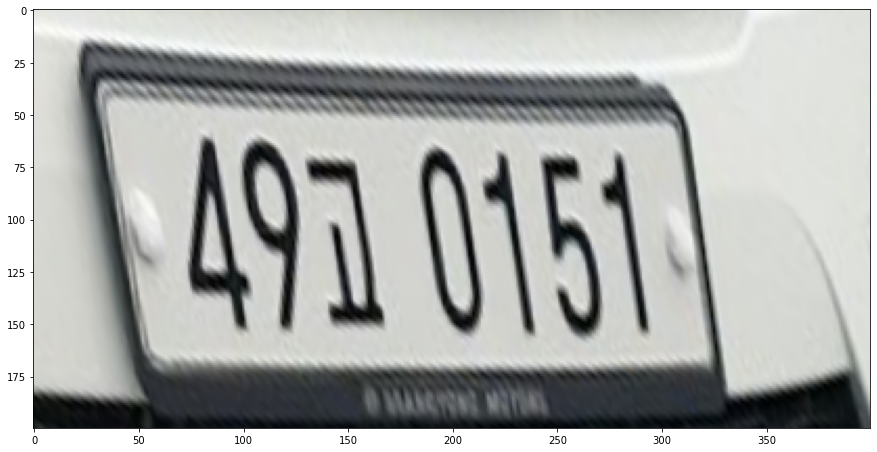

In [595]:
x_sample_concat = np.concatenate((x_sampled_img), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

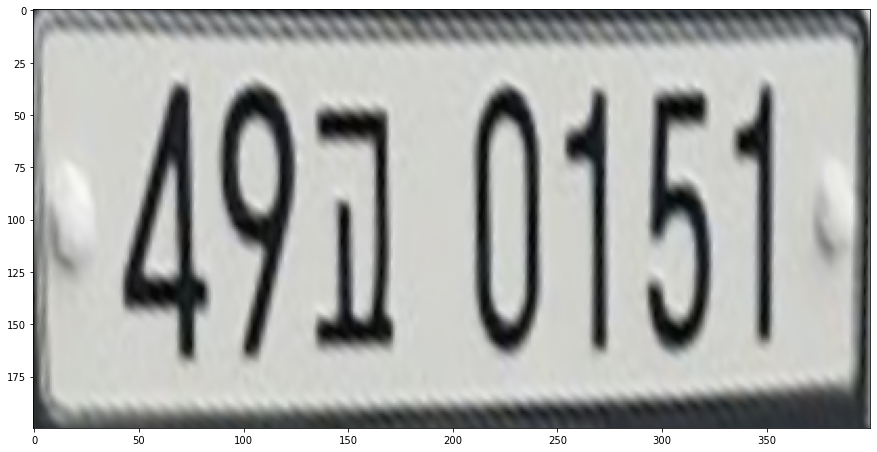

In [596]:
aug_align_mat = generate_transform_matrix(y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y)
x_aug_aligned_sampled = sampling(x_sampled, aug_align_mat[:, :2], 200, 400)
x_aug_aligned_sampled.shape
x_aug_aligned_sampled_img = x_aug_aligned_sampled.numpy().astype(np.uint8)
x_sample_concat = np.concatenate((x_aug_aligned_sampled_img[:10]), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

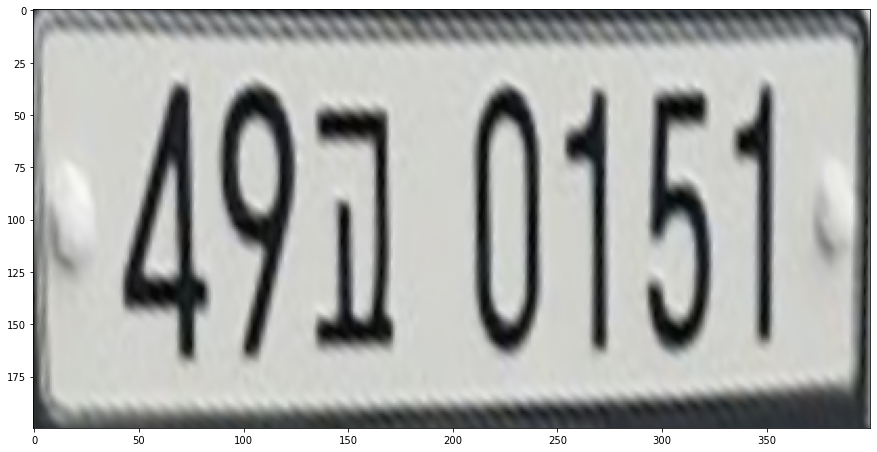

In [597]:
#aug_align_mat = generate_transform_matrix(y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y)
aug_align_mat = generate_transform_matrix(y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y)
x_aug_aligned_sampled = sampling(x_sampled, aug_align_mat[:, :2], 200, 400)
x_aug_aligned_sampled.shape
x_aug_aligned_sampled_img = x_aug_aligned_sampled.numpy().astype(np.uint8)
x_sample_concat = np.concatenate((x_aug_aligned_sampled_img[:10]), axis=1)
plt.figure(figsize=(15,10))
plt.imshow(x_sample_concat)

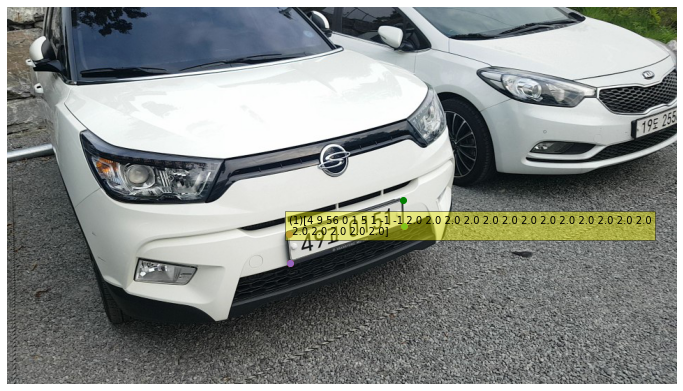

In [598]:
ax = visualize_plate(x_list_test[0], y_list_test[0])

In [599]:
def normalilze_4d(x):
    mini = tf.reduce_min(x, [1, 2], True)
    maxi = tf.reduce_max(x, [1, 2], True)
    return (x - mini) / (maxi - mini)

In [600]:
def image_color_augment(x):
    x = tf.cast(x, tf.float32)
    if tf.random.uniform(()) < 0.2:
        xe = tf.expand_dims(x, 0)
        erosion_dilate_kernel = tf.ones((3, 3, 3))/(3*3*3)#thin char
        xe = tf.nn.dilation2d(xe, erosion_dilate_kernel, [1,1,1,1], 'SAME', 'NHWC', dilations=[1,1,1,1])
        x = x/2 + xe[0]/2
    elif tf.random.uniform(()) < 0.4:
        xe = tf.expand_dims(x, 0)
        erosion_dilate_kernel = tf.ones((3, 3, 3))/(3*3*3)#thic char
        xe = tf.nn.erosion2d(xe, erosion_dilate_kernel, [1,1,1,1], 'SAME', 'NHWC', dilations=[1,1,1,1])
        x = x/2 + xe[0]/2
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
    if tf.random.uniform(()) < 0.2:
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
    if tf.random.uniform(()) < 0.2:
        gray = tf.image.rgb_to_grayscale(x)
        x = tf.concat((gray, gray, gray), -1)
    if tf.random.uniform(()) < -0.2:
        noise = tf.random.normal(tf.shape(x), stddev=tf.sqrt(tf.sqrt(tf.reduce_mean(x))))
        x += noise
    if tf.random.uniform(()) < 0.2:        
        x = gaussian_filter2d(x, filter_shape=3, sigma=5)
    if tf.random.uniform(()) < 0.2:        
        x = sharpness(x, factor=5)    
    if tf.random.uniform(()) < -0.2:  
        x = tf.image.random_jpeg_quality(x, 50, 99)
    if tf.random.uniform(()) < -0.2:  
        x = tf.reduce_max(x, [-1, -2, -3], True) - x
        #x = tf.expand_dims(x0, 0)   
            
    #x = tf.image.random_jpeg_quality(x, 0, 1.0)
    #x = tf.clip_by_value(x, 0, 1)
    x = tf.cast(x, tf.uint8)
    return x

In [601]:
def preprocess_data(X, label):
    
    label = tf.expand_dims(label, 0)
    X = tf.expand_dims(X, 0)
    vertices = label[:, :8]
    plate_type = label[:, 8]
    plate_text = label[:, 9:9 + max_sequence]
    char_cxy = label[:, 9 + max_sequence:9 + max_sequence + max_sequence*2]

    vertices = tf.reshape(vertices, [-1, 4, 2])
    char_cxy = tf.reshape(char_cxy, [-1, max_sequence, 2])
    vertices_uv = convert_norm_to_uv(vertices)
    char_cxy_uv = convert_norm_to_uv(char_cxy)
    align_mat = get_align_matrix(vertices_uv)    
    aug_mat = get_aug_matrix(vertices_uv, delta=0.15)#hyper    
    transform_mat = tf.matmul(align_mat, aug_mat)
    
    X = tf.cast(X, tf.float32)
    x_sampled = sampling(X, transform_mat[:, :2], padded_image_shape[0], padded_image_shape[1])
    transformed_vertices_uv = transform_uv(vertices_uv, transform_mat)
    transformed_char_cxy_uv = transform_uv(char_cxy_uv, transform_mat)
    
    y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y = get_theta_from_coords(transformed_vertices_uv)
    y_align = tf.stack((y_cx, y_cy, y_sx, y_sy, y_shear_x, y_shear_y), -1)
    
    return x_sampled, y_align, plate_text, char_cxy_uv

def preprocess_data_train(X, label):
    X = image_color_augment(X)
    return preprocess_data(X, label)

In [602]:
class LabelEncoder:
    
    def __init__(self):
        pass    
    
    def _encode_sample(self, image_shape, y_align, gt_text, gt_cxy_uv):
        
        y_align = tf.reshape(y_align, [-1])
        gt_text = tf.reshape(gt_text, [-1])
        #is_char = tf.cast(gt_text >= 0, tf.float32)
        gt_text = tf.where(gt_text>=0, gt_text, EOS)
        gt_cxy_uv_flat = tf.reshape(gt_cxy_uv, [-1])
        label = tf.concat([y_align, gt_text, gt_cxy_uv_flat], axis=-1)        
        return label
    
    def encode_batch(self, batch_images, y_align, gt_text, gt_cxy_uv):
        
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]        
                            
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, y_align[i], gt_text[i], gt_cxy_uv[i])
            labels = labels.write(i, label)
        
        batch_images = tf.cast(batch_images, tf.float32)
        label = labels.stack()
        return batch_images, label      
        

In [603]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.models import Model

In [604]:
regulizer = tf.keras.regularizers.L2(l1)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer)(y)   
    
    if downsample:
        x = Conv2D(kernel_size=3,
                   strides=2,
                   filters=filters,
                   activation=activation,
                   padding="same",
                   kernel_regularizer=regulizer)(x)
    out = Add()([x, y])
    out = ReLU()(out)
    return out

def create_resnet_backbone(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer, 
               )(inputs)
    #t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)    
    #num_blocks_list = [2, 2, 2]#resnet-18
    num_blocks_list = [3, 3, 3, 3]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2    
        
    return t


def create_align_net(inputs):
    
    #inputs = Input(shape=(None, None, 3))    
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation=activation,
               padding="same",
               kernel_initializer=kernel_init,
               kernel_regularizer=regulizer, 
               )(inputs)
    t = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(t)
    
    num_blocks_list = [2, 2, 2, 2]#resnet-18
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
    t = Flatten()(t)
    t = Dropout(0.1)(t)
    t = Dense(256, activation=activation, kernel_regularizer=regulizer)(t)
    t = Dense(6, kernel_regularizer=regulizer, name='align')(t)        
    return t

In [605]:
def position_encoding(max_sequence, seq, dimension_model):

    if max_sequence % 2 == 1:
        max_sequence += 1

    pos = tf.range(max_sequence, dtype=tf.float32)
    pos = tf.reshape(pos, [max_sequence, 1])
    theta = pos/tf.pow(10000.0, tf.range(dimension_model, dtype=tf.float32)/dimension_model)
    emb_even = tf.sin(theta)[:, ::2]
    emb_odd = tf.cos(theta)[:, 1::2]
    emb_even_odd = tf.stack((emb_even, emb_odd), axis=-1)
    emb_even_odd = tf.reshape(emb_even_odd, [max_sequence, dimension_model])
    emb = tf.expand_dims(emb_even_odd[:seq], 0)
    return emb

In [606]:
def masked_multi_head_attention(layers, y, num_units, s, head=head_n):
    '''
    :param y: (m, s, c) > padding >(m, S, c)
    :param x: == y
    :param num_units: 256
    :param head: 4
    :return: (m, s, c)
    '''

    z_expand = tf.expand_dims(y, axis=1)
    one = tf.ones_like(z_expand[:1, :, :, 0], dtype=tf.float32)
    one = tf.tile(one, [1, s, 1])
    #triangle_mask = tf.linalg.LinearOperatorLowerTriangular(one).to_dense()#disable on .pb?    
    hot = tf.one_hot(tf.range(s, dtype=tf.int64), s)#(s, s)
    acumulate_hot = []
    for i in range(s):
        row = hot[i]
        for j in range(i):
            row += hot[j]
        
        acumulate_hot.append(row)
    
    triangle_mask = tf.stack(acumulate_hot, axis=0)
    triangle_mask = tf.cast(triangle_mask, tf.float32)            
        
    QKV = layers[0](z_expand)
    #QKV = slim.fully_connected(z_expand, 3 * num_units, activation_fn=None, scope='fc_query_key_value')
    QKV = tf.tile(QKV, [1, s, 1, 1])
    QKV = tf.reshape(QKV, [-1, s, 3 * num_units])

    query, key, value = tf.split(QKV, 3, -1, name='masked_split')

    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    relevant_score = tf.matmul(Q, tf.transpose(K, [0, 2, 1])) / np.sqrt(num_units)  # (m, q_s, c) * (m, c, k_s) = (m, q_s, k_s)
    
    relevant_score = tf.cast(relevant_score, tf.float32)
    triangle_mask = tf.cast(triangle_mask, tf.float32)
    relevant_score += -10000.0 * (1.0 - triangle_mask)        
    
    attention = tf.nn.softmax(relevant_score, axis=-1)
    context = tf.matmul(attention, V)

    attention_list = tf.split(attention, head, axis=0)
    context_list = tf.split(context, head, axis=0)

    attention = tf.reduce_mean(attention_list, axis=0)

    context = tf.concat(context_list, axis=-1)
    context_4d = tf.reshape(context, [-1, s, s, num_units])
    eye = tf.eye(s, s)
    eye = tf.reshape(eye, [1, s, s, 1])
    context = tf.reduce_sum(eye * context_4d, axis=2)
    
    
    if True: 
        context = tf.reduce_sum(context_4d * tf.expand_dims(triangle_mask, -1), axis=1) / tf.reduce_sum(eye, axis=1)        
    else:
        context = tf.reduce_sum(eye * context_4d, axis=2)

    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='Linear')    
    context_ = layers[1](context)
    return context_, attention


In [607]:
def scale_dot_product_2d(query, key, value, s, h, w, num_units):
    print(s, 'Q', query.shape, 'K', key.shape, 'V', value.shape)
    #Q (None, 1, 32) K (None, 4, 12, 32) V (None, 4, 12, 32)
    #m = tf.shape(query)[0]    
    hw = h * w
    c = num_units
    #relevant_score = tf.einsum('msc,mhwc->mhws', query, key) / np.sqrt(num_units)
    query = tf.reshape(query, [-1, s, c])
    query_trans = tf.transpose(query, [0, 2, 1])
    key = tf.reshape(key, [-1, hw, c])
    relevant_score = tf.matmul(key, query_trans) / np.sqrt(num_units)
    
    relevant_score_flat = tf.reshape(relevant_score, [-1, hw, s])
    alignment_weights = tf.nn.softmax(relevant_score_flat, axis=1)

    #alignment_prob = tf.reshape(alignment_weights, tf.shape(relevant_score))
    alignment_prob = tf.reshape(alignment_weights, (-1, hw, s))
    value = tf.reshape(value, (-1, hw, c))

    #context = tf.einsum('mhws,mhwc->msc', alignment_prob, value)
    alignment_prob = tf.transpose(alignment_prob, [0, 2, 1])#(mhws) > (m, s, hw)
    #value = tf.transpose(value, [0, 2, 1])#(m,hw,c) > (m, c, hw)
    context = tf.matmul(alignment_prob, value, name='context_matmul')

    return context, alignment_prob

In [608]:
def multi_head_attention_qkv(layers, y, x, h, w, num_units, s, head=head_n):
    num_head_unit = num_units // head
    #query = slim.fully_connected(y, num_units, activation_fn=None, scope='query')
        
    #key_value = slim.conv2d(x, num_units * 2, kernel_size=[3, 3], scope='key_value')
    
    key = layers[0](x)
    value = layers[1](x)
    #key_value = slim.fully_connected(x, num_units * 2, activation_fn=None, scope='key_value')
    #key, value = tf.split(key_value, 2, -1)
    query = y
    Q = tf.concat(tf.split(query, head, axis=-1), 0)
    K = tf.concat(tf.split(key, head, axis=-1), 0)
    V = tf.concat(tf.split(value, head, axis=-1), 0)

    context, attention = scale_dot_product_2d(Q, K, V, s, h, w, num_head_unit)  # (m * head, s, c)

    attention_head = tf.split(attention, head, axis=0)
    attention_head = tf.stack(attention_head, axis=0)
    attention = tf.reduce_mean(attention_head, axis=0)
    attention = tf.reshape(attention, [-1, s, h, w])
    
    context_list = tf.split(context, head, axis=0)
    context = tf.concat(context_list, axis=-1)
    #context = tf.cond(tf.logical_and(env.is_ensemble_multi_head, is_train), lambda: dropout_sub_head(context_list, head), lambda: tf.concat(context_list, axis=-1))
    #context = slim.fully_connected(context, num_units, activation_fn=None, scope='linear')

    return context, attention

In [609]:
def attention_layer(layers, z, nets, h, w, s, num_units):
    #z (m, S, num_units)
    #x (m, h, w, ch)

    sub_z, attention_weight = masked_multi_head_attention(layers[:2], z, num_units, s)
    z = z + layers[-1](sub_z)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))
    

    sub_z, attention = multi_head_attention_qkv(layers[2:], z, nets, h, w, num_units, s)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))

    #sub_z = position_wise_feed_forward(z, num_units)
    #z = layer_normalize(z + slim.dropout(sub_z, keep_prob=env.drop_prob_transformer, is_training=is_train))
    
    return sub_z, attention

In [610]:
def convert_net_to_score(net, embedding_w):
    embedding_w_trans = tf.transpose(embedding_w)
    score = tf.einsum('nsc,cv->nsv', net, embedding_w_trans)
    return score

In [611]:
def decodeNet(net, num_units, h, w):    
    #embedding = keras.layers.Embedding(input_dim=num_classes, output_dim=num_units, name='embedding')    
    embedding = Dense(num_units, use_bias=False, name='dense_embedding')
    y_symbol = tf.zeros_like(net[:, 0, 0, :1], dtype=tf.int32) + SOS
    
    dense_0 = Dense(3 * num_units, name='masked_Dense_0')
    dense_1 = Dense(num_units, name='masked_Dense_1')
    dense_2 = Dense(num_classes, name='dense_to_score')
    conv_0 = Conv2D(num_units, 3, padding='same', name='key')
    conv_1 = Conv2D(num_units, 3, padding='same', name='value')
    drop = keras.layers.Dropout(0.1)
    layers = [dense_0, dense_1, conv_0, conv_1,drop]
    
    #values = []
    y_start = y_symbol_hot = tf.one_hot(y_symbol, num_classes)
    for i in range(max_sequence):
        
        z = embedding(y_symbol_hot)
        z = z * (num_units ** 0.5) + position_encoding(max_sequence + 1, i + 1, num_units)
        z = drop(z)
                
        z, attention = attention_layer(layers, z, net, h, w, i+1, num_units)
        print('attention',i, attention)        
        value = dense_2(z)
        #value = z[:, :, :num_classes]
        #last_value = value[:, -1:]
        #values.append(last_value)
        
        #y_symbol_hot = tf.concat((y_symbol_hot, tf.nn.softmax(last_value)), axis=1)#decode
        y_symbol_hot = tf.concat((y_start, tf.nn.softmax(value)), axis=1)#decode
        
        #last_cls = tf.argmax(last_value, -1)
        #last_cls = tf.cast(last_cls, tf.int32)
        #y_symbol = tf.concat((y_symbol, last_cls), axis=1)    
    
    #value_stack = tf.stack(values, axis=-2)
    return value, attention

In [612]:
def coordinate_map_uv(h, w):
    #return (6, 18, 256)
    x = tf.range(0.5, w, 1) / tf.cast(w, tf.float32) * 2.0 -1
    y = tf.range(0.5, h, 1) / tf.cast(h, tf.float32) * 2.0 -1
    X, Y = tf.meshgrid(x, y)
    xy = tf.stack((X, Y), -1)
    xy = tf.expand_dims(xy, axis=0)   
    return xy
 

def convert_attention_to_coord(attention, h, w, attention_threshold=0.0):
    if attention_threshold > 0:
        attention = attention * tf.cast(attention > attention_threshold, tf.float32)
        attention = attention / tf.reduce_sum(attention, [1,2], keepdims=True)
    attention_exp = tf.expand_dims(attention, -1)
    coord_map = coordinate_map_uv(h, w)
    
    #before [?,9,4,12,1] * [1,4,12,1,2]. 
    #now    [?,9,4,12,1] * [1,1,4,12,2] > [?, 9, 4, 12, 2]
    attention_coord = attention_exp * tf.expand_dims(coord_map, 1)  # (?, 6, 18, 6, 2)
    char_coord = tf.reduce_sum(attention_coord, [2, 3])  # (?, 6, 2)
    return char_coord


In [613]:
def invert_image(x):
    return tf.reduce_max(x, [1, 2], True) - x

def shadow_image(x):
    input_top, intput_bottom = tf.split(x, 2, axis=1)
    return tf.concat((input_top*0.5, intput_bottom), axis=1) 

In [614]:
padded_image_shape, np.array(padded_image_shape)/32

((96, 288), array([3., 9.]))

In [713]:
def createModel(num_classes):
        
    inputs = Input(shape=(padded_image_shape[0], padded_image_shape[1], 3))        
    inputs_f = normalilze_4d(inputs)
    resnet_stride = 16
    net_h = 6 
    net_w = net_h * 3
    image_h = net_h * resnet_stride
    image_w = net_w * resnet_stride
            
    #inputs_f_resized = tf.image.resize(inputs_f, (image_h, image_w))#tflite
    is_dual = tf.random.uniform(()) < -10.5
    if is_dual:
        #input_inverted = invert_image(inputs_f)
        input_shadow = shadow_image(inputs_f)        
        inputs_con = tf.concat((inputs_f, inputs_f[:, :, ::-1], inputs_f[:, ::-1], inputs_f[:, ::-1, ::-1], input_shadow), 0) 
        h_aligns = create_align_net(inputs_con)  
    else:
        h_align = create_align_net(inputs_f)  
        cx, cy, sx, sy, shear_x, shear_y = tf.squeeze(tf.split(h_align, 6, -1), -1)#test
    #h_align0 = create_align_net(inputs_f)  
    #h_align1 = create_align_net(inputs_f[:, :, ::-1])  
        
    if is_dual:
        aug_k = 5
        h_align0, h_align1, h_align2, h_align3, h_align4 = tf.split(h_aligns, aug_k, 0)
        cx0, cy0, sx0, sy0, shear_x0, shear_y0 = tf.split(h_align0, 6, -1)
        cx1, cy1, sx1, sy1, shear_x1, shear_y1 = tf.split(h_align1, 6, -1)
        cx2, cy2, sx2, sy2, shear_x2, shear_y2 = tf.split(h_align2, 6, -1)
        cx3, cy3, sx3, sy3, shear_x3, shear_y3 = tf.split(h_align3, 6, -1)
        cx4, cy4, sx4, sy4, shear_x4, shear_y4 = tf.split(h_align4, 6, -1)
        
        cx = (cx0 - cx1 + cx2 - cx3 + cx4)/aug_k
        cy = (cy0 + cy1 - cy2 - cy3 + cy4)/aug_k
        sx = (sx0 + sx1 + sx2 + sx3 + sx4)/aug_k
        sy = (sy0 + sy1 + sy2 + sy3 + sy4)/aug_k
        shear_x = (shear_x0 - shear_x1 - shear_x2 + shear_x3 + shear_x4)/aug_k
        shear_y = (shear_y0 - shear_y1 - shear_y2 + shear_y3 + shear_y4)/aug_k
        h_align = tf.concat((cx, cy, sx, sy, shear_x, shear_y), -1)            

    aug_align_mat = generate_transform_matrix(cx, cy, sx + scale_margin, sy + scale_margin*2, shear_x, shear_y)
    inputs_aligned = sampling(inputs_f, aug_align_mat[:, :2], image_h, image_w)
            
    #inputs_aligned = tf.image.resize(inputs_f, (image_h, image_w))*0.99 + inputs_aligned*0.01    
    
    if is_dual:
        input_inverted = invert_image(inputs_aligned)        
        input_shadow = shadow_image(inputs_aligned)
        input_inverted = tf.concat((inputs_aligned, input_inverted, input_shadow), axis=0)
        net_invert = create_resnet_backbone(input_inverted)
        net0, net1, net2 = tf.split(net_invert, 3, 0)
        net = (net0 + net1 + net2) / 3
    else:
        net = create_resnet_backbone(inputs_aligned)
        
    scores, attention = decodeNet(net, 256, net_h, net_w)
  
    char_cxy_uv = convert_attention_to_coord(attention, net_h, net_w, 0.0001)
    print('h_char_cxy_uv', char_cxy_uv)
    char_cxy_uv = tf.reshape(char_cxy_uv, [-1, max_sequence, 2])
    scores = tf.reshape(scores, [-1, max_sequence, num_classes])
    
    output_decoder = tf.concat((char_cxy_uv, scores), -1)        
    output_decoder_flat = tf.reshape(output_decoder, [-1, max_sequence * (2 + num_classes)])
    output = tf.concat((h_align, output_decoder_flat), -1)
    print('final_output', output)
    
    model = keras.Model(inputs=inputs, outputs=output)    
    return model

In [642]:
class AlignLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self):
        super(AlignLoss, self).__init__(reduction="auto", name="AlignLoss")        
        pass

    def call(self, y_true, y_pred):
        #is_valid = tf.cast(tf.abs(y_true) < 0.99, tf.float32)
        loss = tf.reduce_sum(tf.square(y_true - y_pred), -1)
        return loss

class DecodeLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes):
        super(DecodeLoss, self).__init__(reduction="auto", name="DecodeLoss")        
        self._num_classes = num_classes
        self._gamma = 2

    def call(self, y_decoder, h_decoder):
        h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + self._num_classes])
        
        y_text = tf.cast(y_decoder[:, :max_sequence], tf.int64)
        y_char_cxy = y_decoder[:, max_sequence:]
        y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])
        
        h_char_cxy = h_decoder[:, :, :2]
        h_text_score = h_decoder[:, :, 2:]
        h_text = tf.argmax(h_text_score, -1)        
        
        valid_mask_f = tf.cast(y_text < SOS, tf.float32)
        valid_mask_i = tf.cast(y_text < SOS, tf.int64)
        
        text_correct = tf.cast(tf.equal(y_text, h_text), tf.int64) * valid_mask_i * tf.range(max_sequence, dtype=tf.int64)#(m, seq)
        text_correct_hot = tf.one_hot(text_correct, max_sequence)#(m,seq,seq)
        text_correct_hot_axis_1 = tf.reduce_sum(text_correct_hot, axis=1)
        loss_text_mask = tf.concat((tf.ones_like(text_correct_hot_axis_1[:, :1]), text_correct_hot_axis_1[:, :-1]), -1)
        loss_text_mask = tf.cast(loss_text_mask, tf.float32)
        loss_text_mask = 1
        
        weight_char = tf.range(max_sequence, dtype=tf.float32)[::-1]
        weight_char = tf.reshape(weight_char, [1, -1]) / (max_sequence/2)
        
        y_hot = tf.one_hot(y_text, self._num_classes)
        cls_pt = tf.nn.softmax(h_text_score)        
        cls_pt = tf.clip_by_value(cls_pt, 1e-7, 1.0 - 1e-7)
        loss_cls_p = - tf.pow(1.0 - cls_pt, self._gamma) * y_hot * tf.math.log(cls_pt)
        loss_cls_f = - tf.pow(cls_pt, self._gamma) * (1 - y_hot) * tf.math.log(1 - cls_pt)
        
        loss_cls = loss_text_mask * tf.reduce_sum(loss_cls_p + loss_cls_f, axis=-1)
        
        has_cxy_label = tf.cast(tf.abs(y_char_cxy) < 0.99, tf.float32)
        loss_cxy = tf.abs(y_char_cxy - h_char_cxy)
        loss_cxy = tf.reduce_sum(has_cxy_label * loss_cxy, -1)
        
        #loss = valid_mask_f * loss_cls
        loss = valid_mask_f * loss_cxy + loss_cls                
        return loss

    
class CxyLoss(tf.losses.Loss):
    
    def __init__(self, num_classes):
        super(CxyLoss, self).__init__(reduction="auto", name="CxyLoss")        
        self._num_classes = num_classes

    def call(self, y_decoder, h_decoder):
        h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + self._num_classes])
        
        y_text = tf.cast(y_decoder[:, :max_sequence], tf.int64)
        y_char_cxy = y_decoder[:, max_sequence:]
        y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])
        
        h_char_cxy = h_decoder[:, :, :2]        
        
        valid_mask_f = tf.cast(y_text > -1, tf.float32)
                        
        has_cxy_label = tf.cast(tf.abs(y_char_cxy) < 0.99, tf.float32)
        loss_cxy = tf.abs(y_char_cxy - h_char_cxy)
        loss_cxy = tf.reduce_sum(has_cxy_label * loss_cxy, -1)        
        loss = valid_mask_f * loss_cxy                
        return loss

class NetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes):
        super(NetLoss, self).__init__(reduction="auto", name="NetLoss")        
        self._alignLoss = AlignLoss()
        self._decodeLoss = DecodeLoss(num_classes)
        self._cxyLoss = CxyLoss(num_classes)

    def call(self, y_true, y_pred):
        y_align = y_true[:, :6]
        y_decoder = y_true[:, 6:]
        
        h_align = y_pred[:, :6]
        h_decoder = y_pred[:, 6:]
        
        loss_align = self._alignLoss(y_align, h_align)
        
        loss_cls = self._decodeLoss(y_decoder, h_decoder)        
        loss_cxy = self._cxyLoss(y_decoder, h_decoder)        
        
        loss_cls = tf.maximum(0.0, loss_cls - tf.stop_gradient(loss_align))
        loss_cxy = tf.maximum(0.0, loss_cxy - tf.stop_gradient(loss_align))
        
        #loss_decode = loss_cxy + loss_cls        
        #y_text = y_decoder[:, :max_sequence]
        #loss_align = tf.where(y_text < SOS, y_text, y_text * 0)
        
        loss = loss_align + loss_cxy + loss_cls
        return loss

In [643]:
def distance(y_true, y_pred):
    y_align = y_true[:, :6]
    y_decoder = y_true[:, 6:]

    h_align = y_pred[:, :6]
    h_decoder = y_pred[:, 6:]
    
    return tf.reduce_mean(tf.abs(y_align - h_align))

def _acc(y_true, y_pred):    
    y_text = tf.cast(y_true[:, :max_sequence], tf.int64)
    y_char_cxy = y_true[:, max_sequence:]
    y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])

    h_char_cxy = y_pred[:, :, :2]
    h_text_score = y_pred[:, :, 2:]
    h_text = tf.argmax(h_text_score, -1)

    valid_mask = tf.logical_and(y_text > -1, y_text < EOS)
    
    acc = tf.boolean_mask(tf.equal(y_text, h_text), valid_mask)    
    return acc


def _acc_plate(y_true, y_pred):    
    y_text = tf.cast(y_true[:, :max_sequence], tf.int64)
    y_char_cxy = y_true[:, max_sequence:]
    y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])

    h_char_cxy = y_pred[:, :, :2]
    h_text_score = y_pred[:, :, 2:]
    h_text = tf.argmax(h_text_score, -1)

    valid_mask = y_text > -1    
    
    eq = tf.reduce_all(tf.equal(y_text, h_text), -1)
    acc = tf.cast(eq, tf.float32)    
    return acc


def accuracy(y_true, y_pred):
    y_align = y_true[:, :6]
    y_decoder = y_true[:, 6:]

    h_align = y_pred[:, :6]
    h_decoder = y_pred[:, 6:]
    
    h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + num_classes])      
    return _acc(y_decoder, h_decoder)

def accuracy_a(y_true, y_pred):
    y_align = y_true[:, :6]
    y_decoder = y_true[:, 6:]

    h_align = y_pred[:, :6]
    h_decoder = y_pred[:, 6:]
    
    h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + num_classes])      
    return _acc_plate(y_decoder, h_decoder)


def dist_cxy(y_true, y_pred):
    y_align = y_true[:, :6]
    y_decoder = y_true[:, 6:]

    h_align = y_pred[:, :6]
    h_decoder = y_pred[:, 6:]
    
    y_text = tf.cast(y_decoder[:, :max_sequence], tf.int64)
    y_char_cxy = y_decoder[:, max_sequence:]
    y_char_cxy = tf.reshape(y_char_cxy, [-1, max_sequence, 2])
    
    h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + num_classes])        
    h_cxy = h_decoder[:,:,:2]
    
    valid_mask = tf.abs(y_char_cxy) < 0.99
    dist = tf.abs(y_char_cxy - h_cxy)
    return tf.boolean_mask(dist, valid_mask)    

In [644]:
def load_weight():   
    weights_dir = path_weight
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [645]:
label_encoder = LabelEncoder()

In [646]:
#x_list_train, y_list_train

In [647]:
def generator():
    m = len(x_list_train)    
    for i in range(m):
        x = x_list_train[i]
        y_box = y_list_train[i]        
        yield (x, y_box)

def generator_test():
    m = len(x_list_test)    
    for i in range(m):
        x = x_list_test[i]
        y_box = y_list_test[i]        
        yield (x, y_box)
        
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([36])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([36])))

In [648]:
#dataset = tf.data.Dataset.from_tensor_slices((input_list_train, bbox_list_train))

In [649]:
np.set_printoptions(precision=2)
print(dataset)
for example in tfds.as_numpy(dataset):
    print('example', len(example))
    image = example[0]
    bbox = example[1]    
    print(image.dtype, bbox.dtype, image.shape, bbox.shape, bbox)
    break

<FlatMapDataset shapes: ((None, None, 3), (36,)), types: (tf.uint8, tf.float32)>
example 2
uint8 float32 (540, 960, 3) (36,) [ 0.42  0.6   0.59  0.51  0.59  0.58  0.42  0.68  1.    4.    9.   56.
  0.    1.    5.    1.   -1.   -1.    2.    2.    2.    2.    2.    2.
  2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    2.  ]


In [650]:
batch_size = 1
autotune = tf.data.experimental.AUTOTUNE
#dataset = dataset.batch(batch_size)
train_dataset = dataset.map(preprocess_data_train, num_parallel_calls=autotune)
#train_dataset = train_dataset.batch(batch_size)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size)
#train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

test_dataset = dataset_test.map(preprocess_data, num_parallel_calls=autotune)
test_dataset = test_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
test_dataset = test_dataset.apply(tf.data.experimental.ignore_errors())
test_dataset = test_dataset.prefetch(autotune)


In [651]:
for x, y in train_dataset:
    print(y.shape)
    y = y[0]
    y_align = y[:6]
    y_recog = y[6:]
    y_recog_text = y_recog[:max_sequence]
    y_recog_cxy = y_recog[max_sequence:]
    print(y_align)
    print('y_recog_text', y_recog_text)
    print('y_recog_cxy', tf.reshape(y_recog_cxy, [-1, 2]))
    break

(1, 33)
tf.Tensor([ 0.06 -0.05  0.75  0.79  0.02  0.12], shape=(6,), dtype=float32)
y_recog_text tf.Tensor([  4.   9.  56.   0.   1.   5.   1. 117. 117.], shape=(9,), dtype=float32)
y_recog_cxy tf.Tensor(
[[3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]
 [3. 3.]], shape=(9, 2), dtype=float32)


In [714]:
#optimizer = tf.optimizers.SGD(learning_rate=1e-4, clipvalue=5.)#warm up clipvalue=10. !
optimizer = tf.optimizers.SGD(learning_rate=1e-0, clipvalue=10.)#, clipvalue=10.
loss_fn = NetLoss(num_classes)

model = createModel(num_classes)
model.compile(loss=loss_fn , optimizer=optimizer, metrics=[distance, dist_cxy, accuracy, accuracy_a])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_weight,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
        save_freq=500
    )
]

1 Q (None, 1, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 0 Tensor("Reshape_3589:0", shape=(None, 1, 6, 18), dtype=float32)
2 Q (None, 2, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 1 Tensor("Reshape_3597:0", shape=(None, 2, 6, 18), dtype=float32)
3 Q (None, 3, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 2 Tensor("Reshape_3605:0", shape=(None, 3, 6, 18), dtype=float32)
4 Q (None, 4, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 3 Tensor("Reshape_3613:0", shape=(None, 4, 6, 18), dtype=float32)
5 Q (None, 5, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 4 Tensor("Reshape_3621:0", shape=(None, 5, 6, 18), dtype=float32)
6 Q (None, 6, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 5 Tensor("Reshape_3629:0", shape=(None, 6, 6, 18), dtype=float32)
7 Q (None, 7, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
attention 6 Tensor("Reshape_3637:0", shape=(None, 7, 6, 18), dtype=float32)
8 Q (None, 8, 32) K (None, 6, 18, 32) V (None, 6, 18, 32)
atte

In [715]:
model.load_weights(path_weight)

In [654]:
scalar = model.evaluate(train_dataset.take(10))

10/10 [==============================] - 0s 29ms/step - loss: 0.0230 - distance: 0.0278 - dist_cxy: 0.0236 - accuracy: 1.0000 - accuracy_a: 1.0000


In [716]:
scalar = model.evaluate(test_dataset)#0.956

734/734 [==============================] - 15s 20ms/step - loss: 0.0067 - distance: 0.0224 - dist_cxy: 0.0000e+00 - accuracy: 0.9994 - accuracy_a: 0.9959


In [656]:
len(x_list_train), len(x_list_test)

(8453, 734)

In [667]:
epochs = 100000
hist = model.fit(
    train_dataset.take(10000),
    validation_data=None,#val_dataset.take(2)
    epochs=epochs, 
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)# b1:64ms, b2:62ms, b5:62ms
# 249s 40ms/step - loss: 3.7678 - distance: 0.0066 - dist_vertex: 0.1146 - accuracy: 0.0036
#align single ms :55~56, quad:60, quad x dual:68
#- 394s 56ms/step - loss: 0.2003 - distance: 0.0242 - dist_cxy: 0.0539 - accuracy: 0.9529 - accuracy_a: 0.7301

Epoch 1/100000
8453/8453 [==============================] - 422s 50ms/step - loss: 0.1042 - distance: 0.0285 - dist_cxy: 0.0292 - accuracy: 0.9878 - accuracy_a: 0.9317
Epoch 2/100000
8453/8453 [==============================] - 422s 50ms/step - loss: 0.0919 - distance: 0.0269 - dist_cxy: 0.0275 - accuracy: 0.9918 - accuracy_a: 0.9539
Epoch 3/100000
8453/8453 [==============================] - 422s 50ms/step - loss: 0.0912 - distance: 0.0271 - dist_cxy: 0.0270 - accuracy: 0.9917 - accuracy_a: 0.9556
Epoch 4/100000
8453/8453 [==============================] - 425s 50ms/step - loss: 0.0904 - distance: 0.0263 - dist_cxy: 0.0271 - accuracy: 0.9922 - accuracy_a: 0.9553
Epoch 5/100000
8453/8453 [==============================] - 424s 50ms/step - loss: 0.0860 - distance: 0.0256 - dist_cxy: 0.0263 - accuracy: 0.9929 - accuracy_a: 0.9603
Epoch 6/100000
8453/8453 [==============================] - 424s 50ms/step - loss: 0.0861 - distance: 0.0258 - dist_cxy: 0.0261 - accuracy: 0.9929 - accuracy_a:

8453/8453 [==============================] - 425s 50ms/step - loss: 0.0693 - distance: 0.0222 - dist_cxy: 0.0221 - accuracy: 0.9957 - accuracy_a: 0.9776
Epoch 50/100000
8453/8453 [==============================] - 421s 50ms/step - loss: 0.0707 - distance: 0.0220 - dist_cxy: 0.0221 - accuracy: 0.9956 - accuracy_a: 0.9780
Epoch 51/100000
8453/8453 [==============================] - 420s 50ms/step - loss: 0.0678 - distance: 0.0217 - dist_cxy: 0.0220 - accuracy: 0.9965 - accuracy_a: 0.9797
Epoch 52/100000
8453/8453 [==============================] - 422s 50ms/step - loss: 0.0660 - distance: 0.0215 - dist_cxy: 0.0215 - accuracy: 0.9969 - accuracy_a: 0.9807
Epoch 53/100000
8453/8453 [==============================] - 421s 50ms/step - loss: 0.0662 - distance: 0.0217 - dist_cxy: 0.0215 - accuracy: 0.9968 - accuracy_a: 0.9824
Epoch 54/100000
8453/8453 [==============================] - 420s 50ms/step - loss: 0.0715 - distance: 0.0226 - dist_cxy: 0.0223 - accuracy: 0.9952 - accuracy_a: 0.9753
Ep

KeyboardInterrupt: 

In [668]:
model.save_weights(path_weight)

In [726]:
def convert_class_num_to_class_symbol(cls):
    return ''.join([plate_characters[i] for i in np.reshape(cls, [-1])] )

In [717]:
def check_error(dataset, max_display):
    check_count = 0
    wrong_count = 0
    for image, label in dataset: 

        y_decode = label[:, 6:]
        y_cls = tf.cast(y_decode[:, :max_sequence], tf.int64)
        y_cxy = tf.reshape(y_decode[:, max_sequence:],[-1,max_sequence,2])
        output = model.predict(image)
        #print('output', output.shape)
        output_decode = tf.reshape(output[:, 6:], [-1, max_sequence, 2 + num_classes])
        cxy = output_decode[:, :, :2]
        cls_score = output_decode[:, :, 2:]
        #h_text_score = y_pred[:, :, 2:]
        #h_text = tf.argmax(h_text_score, -1)
        #print('cls_score', cls_score.shape)
        cls = tf.argmax(cls_score, -1)    
        if tf.logical_not(tf.reduce_all(tf.equal(y_cls, cls))):
            print('y',  ''.join([plate_characters[i] for i in np.reshape(y_cls, [-1])] ))
            print('h', ''.join([plate_characters[i] for i in np.reshape(cls, [-1])] ))
            #print('y_cxy', tf.transpose(y_cxy, [0, 2, 1]))
            #print(check_count, wrong_count, 'cxy',tf.transpose(cxy, [0, 2, 1]).numpy())
            #print('')
            plt.imshow(image[0].numpy().astype(np.uint8))
            plt.show()
            wrong_count+=1
        check_count +=1
        if wrong_count > max_display:
            print('check_count', check_count)
            break

In [671]:
plate_characters

'0123456789ABCDEFGHIJKLMNPQRSTUVWXYZ-가나다라마바사아자하거너더러머버서어저허고노도로모보소오조호구누두루무부수우주대배해제기교표외인천국합육공영준협정울경강원충북운남전산광_       abcd  '

In [672]:
plate_characters[47]

'너'

y 60마1893  
h 60머1893  


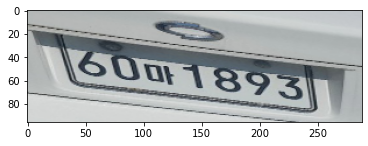

y 61구6121  
h 66구6121  


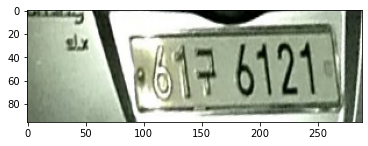

In [719]:
check_error(test_dataset, max_display=100)

In [674]:
padded_image_shape

(96, 288)

In [675]:
def decodePredictions(y_pred):
    h_align = y_pred[:, :6]
    h_decoder = y_pred[:, 6:]
    h_decoder = tf.reshape(h_decoder, [-1, max_sequence, 2 + num_classes])
  
    h_char_cxy = h_decoder[:, :, :2]
    h_text_score = h_decoder[:, :, 2:]
    h_text = tf.argmax(h_text_score, -1)        
    return h_text    

In [676]:
input_resize = input_image = tf.keras.Input(shape=[None, None, 3], name="image")
#input_resize = tf.image.resize(input_image, padded_image_shape)
predictions = model(input_resize)
predict_text = decodePredictions(predictions)
inference_model = tf.keras.Model(inputs=input_resize, outputs=predict_text)

In [685]:
x_list_train[1].shape

(540, 960, 3)

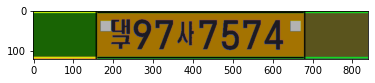

In [705]:
x0 = x_list_train[12][50:-50,100:-100]
#plt.figure(figsize=(15,10))
ax = plt.imshow(x0)

In [706]:
output = inference_model.predict(np.expand_dims(x0, 0))
output.shape, output

((4, 9),
 array([[ 75,  66,   9,   7,  42,   1,   5,   4,   4],
        [  1,  93,   1,   1,   1,   1,   1, 117, 117],
        [  1,  93,   1,   1,   1,   1,   1, 117, 117],
        [  1,  93,   1,   1,   1,   1,   1, 117, 117]]))

### tflite

In [720]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp54lijafw/assets


INFO:tensorflow:Assets written to: /tmp/tmp54lijafw/assets


In [721]:
# Save the TF Lite model.
tflite_path = 'LPR_v0.1.tflite'
with tf.io.gfile.GFile(tflite_path, 'wb') as f:
  f.write(tflite_model)
!ls *.tflite

LPR_v0.1.tflite  LPR_v0.tflite	LPR_v01.tflite


(1, 96, 288, 3) uint8


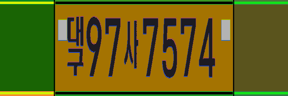

In [722]:
img_resized = img = Image.fromarray(x0)
img_resized = img.resize((padded_image_shape[1],padded_image_shape[0]))
input_sample = np.expand_dims(np.array(img_resized), 0)
print(input_sample.shape, input_sample.dtype)
img_resized

In [723]:
num_classes, num_classes * max_sequence, (2+num_classes) * max_sequence, 6+ (2+num_classes) * max_sequence

(118, 1062, 1080, 1086)

In [724]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
#interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('input_details', input_details)
print('output_details', output_details)

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(input_sample, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
tflite_results = interpreter.get_tensor(output_details[0]['index'])
tflite_results.shape

input_details [{'name': 'image', 'index': 0, 'shape': array([  1,  96, 288,   3], dtype=int32), 'shape_signature': array([ -1,  96, 288,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details [{'name': 'Identity', 'index': 1788, 'shape': array([1, 9], dtype=int32), 'shape_signature': array([-1,  9], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


(1, 9)

In [727]:
tflite_results, convert_class_num_to_class_symbol(tflite_results)

(array([[75, 66,  9,  7, 42,  7,  5,  7,  4]]), '대구97사7574')

In [119]:
for var in model.trainable_variables:
    print(var.name, var.shape)

conv2d_192/kernel:0 (7, 7, 3, 64)
conv2d_192/bias:0 (64,)
conv2d_193/kernel:0 (3, 3, 64, 64)
conv2d_193/bias:0 (64,)
conv2d_194/kernel:0 (3, 3, 64, 64)
conv2d_194/bias:0 (64,)
conv2d_195/kernel:0 (3, 3, 64, 64)
conv2d_195/bias:0 (64,)
conv2d_196/kernel:0 (3, 3, 64, 64)
conv2d_196/bias:0 (64,)
conv2d_197/kernel:0 (3, 3, 64, 128)
conv2d_197/bias:0 (128,)
conv2d_199/kernel:0 (3, 3, 64, 128)
conv2d_199/bias:0 (128,)
conv2d_198/kernel:0 (3, 3, 128, 128)
conv2d_198/bias:0 (128,)
conv2d_200/kernel:0 (3, 3, 128, 128)
conv2d_200/bias:0 (128,)
conv2d_201/kernel:0 (3, 3, 128, 128)
conv2d_201/bias:0 (128,)
conv2d_202/kernel:0 (3, 3, 128, 256)
conv2d_202/bias:0 (256,)
conv2d_204/kernel:0 (3, 3, 128, 256)
conv2d_204/bias:0 (256,)
conv2d_203/kernel:0 (3, 3, 256, 256)
conv2d_203/bias:0 (256,)
conv2d_205/kernel:0 (3, 3, 256, 256)
conv2d_205/bias:0 (256,)
conv2d_206/kernel:0 (3, 3, 256, 256)
conv2d_206/bias:0 (256,)
conv2d_207/kernel:0 (3, 3, 256, 512)
conv2d_207/bias:0 (512,)
conv2d_209/kernel:0 (3, 3,